# Patch Foraging Simulation

## Initial setup

In [1]:
import numpy as np
import math
from random import random
import matplotlib.pyplot as plt
% matplotlib inline

## Fixed Model

### Create environment

In [2]:
class PatchEnvironment:
    
    def __init__(self,
                 d_interpatch, 
                 r_init, 
                 decay=0.1,
                 nc_avg=1.0,
                 target_duration=1.0,
                 max_trial_duration=4.0,
                 iti=1.5,
                 fa_timeout=4.0,
                 end_patch_type=None,
                 end_patch_val=None):
        
        # Patch settings
        self.d_interpatch = d_interpatch
        self.r_init = r_init
        self.decay = decay
        self.nc_avg = nc_avg
        self.target_duration = target_duration
        self.max_trial_duration = max_trial_duration
        self.iti = iti
        self.fa_timeout = fa_timeout
        self.end_patch_type = end_patch_type
        self.end_patch_val = end_patch_val
        
        # Tracking indices
        self.trial = 0
         
    def reset_patch(self):
        self.trial = 0
    
    def create_trial(self):
        """
        Creates trial based on patch settings. If patch is depleted, then return no targets.
        Otherwise, return delay to target sampled from exponential distribution (flat hazard rate).
        
        Returns:
        - nc_time: duration of delay to target
        - catch_trial: True if catch trial
        """
        if self.is_patch_depleted():
            return self.max_trial_duration, False
        else:
            lambda_ = 1.0 / self.nc_avg
            nc_time = -(1.0/lambda_) * math.log(1.0 - random()) # inverse transform sampling of exponential distribution
            
            if nc_time > self.max_trial_duration:
                nc_time = self.max_trial_duration
                catch_trial = True
            else:
                catch_trial = False
            
            return nc_time, catch_trial
    
    def give_reward(self):
        # Give current reward volume based on reward function and patch end function
        if self.is_patch_depleted():
            return 0.0
        else:
            return self._get_reward_volume()
    
    def increment_counter(self, n=1):
        self.trial += n
    
    def _get_reward_volume(self):
        return self.r_init * (1 - self.decay)**self.trial
    
    def is_patch_depleted(self):
        if self.end_patch_type == None:
            return False
        elif self.end_patch_type == 'reward':
            return self._get_reward_volume() < self.end_patch_val
        elif self.end_patch_type == 'trial':
            return self.trial >= self.end_patch_val
        else:
            raise ValueError('Unknown end patch type %s' % self.end_patch_type)

In [3]:
class Rodent:
    
    def __init__(self, 
                 hit_rate, 
                 fa_rate, 
                 velocity, 
                 decision_type='reward', 
                 decision_val=2.0):
        
        self.hit_rate = hit_rate
        self.fa_rate = fa_rate
        self.velocity = velocity
        self.decision_type = decision_type
        self.decision_val = decision_val
        
        self.result_idx = {'hit': 0,
                           'miss': 1,
                           'false_alarm': 2,
                           'catch': 3}
        
    def leave_patch(self, last_reward, t_patch, n_patch):
        """
        Either choose to stay in patch (and harvest reward) or leave patch (and incur travel time delay).
        Args:
        - last_reward: last reward harvested in patch (or 0 if none harvested)
        - t_patch: time spent in current patch
        - n_patch: number of trials in current patch
        
        Returns:
        - boolean that is True if animal decides to leave patch
        """
        
        if self.decision_type == 'reward':
            if n_patch == 0:
                return False
            else:
                return last_reward <= self.decision_val
        elif self.decision_type == 'time':
            return t_patch >= self.decision_val
        elif self.decision_type == 'trial':
            return n_patch >= self.decision_val
        else:
            raise ValueError('Decision type %s not recognized.' % self.decision_type)
    
    def harvest_reward(self, nc_duration, target_duration, catch_trial=False):
        """
        Attempt to collect reward given limitations of parameters.
        Args:
        - nc_duration: delay to target start
        - target_duration: length of target tone
        - catch_trial: True if catch trial
        
        Returns:
        - result: indexed result based on dictionary above
        - t_result: time from trial start to when result occurred
        """
        
        num_blocks = int(nc_duration / target_duration)
        fa_in_block = self.fa_rate > np.random.rand(num_blocks) # true if FA in time block
        false_alarm = np.sum(fa_in_block) > 0 # FA occurred in any time block
        
        # False alarm
        if false_alarm:
            return self.result_idx['false_alarm'], np.nonzero(fa_in_block)[0][0]
        
        # Get reward if no false alarm during catch trial
        elif catch_trial:
            return self.result_idx['catch'], nc_duration

        # Otherwise, get reward based on hit rate
        elif self.hit_rate > random():
            return self.result_idx['hit'], nc_duration + target_duration / 2
        else:
            return self.result_idx['miss'], nc_duration + target_duration
    
    def get_travel_time(self, distance):
        return distance / self.velocity

In [7]:
def run_simulation(num_steps, mouse, patch, verbose=False):

    n_patch = 0 # trial number
    t_patch = 0.0 # time in patch
    t_total = 0.0 # total time
    r_total = 0.0 # total reward harvested
    num_patches = 1 # number of patches explored
    r_last = math.inf # last reward in patch

    for i in range(num_steps):

        # Make stay or go decision
        leave = mouse.leave_patch(r_last, t_patch, n_patch)

        # If leave, incur travel cost and reset patch
        if leave:
            r_step = 0.0
            t_step = mouse.get_travel_time(patch.d_interpatch)
            n_patch = 0
            t_patch = 0.0
            r_last = math.inf
            num_patches += 1
            patch.reset_patch()

        # Otherwise, attempt signal detection task to harvest reward
        else:
            # Get trial from patch
            nc_time, catch_trial = patch.create_trial()
            result, t_result = mouse.harvest_reward(nc_time, patch.target_duration, catch_trial)

            # Penalize with timeout if false alarm
            if (result == 2):
                r_step = 0.0
                t_step = t_result + patch.fa_timeout + patch.iti

            # Get reward if hit or successful catch trial
            elif (result == 0) or (result == 3): 
                r_step = patch.give_reward()
                r_last = r_step
                t_step = nc_time + patch.target_duration * (1 - catch_trial) + patch.iti

            # Do not reward but do not penalize if miss
            elif (result == 1):
                r_step = 0.0
                t_step = nc_time + patch.target_duration + patch.iti

            else:
                raise ValueError('Unknown result index: %d' % result)

            # Increment patch counters
            patch.increment_counter()
            n_patch += 1
            t_patch += t_step

        # Increment global counters
        t_total += t_step
        r_total += r_step

        # Print progress
        if verbose and (i % 100 == 0):
            print("Step %d" % i)
    
    if verbose:
        harvest_rate = r_total / t_total
        print("Total reward: %.2f uL" % r_total)
        print("Total time: %.2f s" % t_total)
        print("Harvest rate: %.3f uL/s" % harvest_rate)
    
    return r_total, t_total, num_patches

### Sanity check
Step-by-step walkthrough to check for blatant errors.

In [ ]:
n_patch = 0 # trial number
t_patch = 0.0 # time in patch
t_total = 0.0 # total time
r_total = 0.0 # total reward harvested
num_patches = 1 # number of patches explored
r_last = math.inf # last reward in patch
verbose = True
num_steps = 10

for i in range(num_steps):

    # Make stay or go decision
    leave = mouse.leave_patch(r_last, t_patch, n_patch)

    # If leave, incur travel cost and reset patch
    if leave:
        r_step = 0.0
        t_step = mouse.get_travel_time(patch.d_interpatch)
        n_patch = 0
        t_patch = 0.0
        r_last = math.inf
        num_patches += 1
        patch.reset_patch()

    # Otherwise, attempt signal detection task to harvest reward
    else:
        # Get trial from patch
        nc_time, catch_trial = patch.create_trial()
        result, t_result = mouse.harvest_reward(nc_time, patch.target_duration, catch_trial)

        # Penalize with timeout if false alarm
        if (result == 2):
            r_step = 0.0
            t_step = t_result + patch.fa_timeout + patch.iti

        # Get reward if hit or successful catch trial
        elif (result == 0) or (result == 3): 
            r_step = patch.give_reward()
            r_last = r_step
            t_step = nc_time + patch.target_duration * (1 - catch_trial) + patch.iti

        # Do not reward but do not penalize if miss
        elif (result == 1):
            r_step = 0.0
            t_step = nc_time + patch.target_duration + patch.iti

        else:
            raise ValueError('Unknown result index: %d' % result)

        # Increment patch counters
        patch.increment_counter()
        n_patch += 1
        t_patch += t_step

    # Increment global counters
    t_total += t_step
    r_total += r_step

    # Print progress
    if verbose and (i % 100 == 0):
        print("Step %d" % i)

if verbose:
    harvest_rate = r_total / t_total
    print("Total reward: %.2f uL" % r_total)
    print("Total time: %.2f s" % t_total)
    print("Harvest rate: %.3f uL/s" % harvest_rate)

### Hit rate = 1.0, FA rate = 0.0 (control)

#### Run simulation

In [30]:
# Environment parameters
d_interpatch = 25.0
r_init = 12.0
decay = 0.1
nc_avg = 1.0
target_duration = 1.0
max_trial_duration = 4.0
iti = 1.5
fa_timeout = 4.0
end_patch_type = None
end_patch_val = None

# Animal parameters
hit_rate = 1.0
fa_rate = 0.0
velocity = 5.0
decision_type = 'reward'
decision_val = np.linspace(2.0, 12.0, num=int((12.0-2.0)/0.1)+1)

# Experiment parameters
exp_name = 'trial_1'
num_steps_per_sim= 1000
num_sims_per_value = 5

# Create environment
patch = PatchEnvironment(d_interpatch,
                         r_init, 
                         decay,
                         nc_avg=nc_avg,
                         target_duration=target_duration,
                         max_trial_duration=max_trial_duration,
                         iti=iti,
                         fa_timeout=fa_timeout,
                         end_patch_type=end_patch_type,
                         end_patch_val=end_patch_val)

# Run simulations
r_total = np.zeros([decision_val.shape[0], num_sims_per_value])
t_total = np.zeros([decision_val.shape[0], num_sims_per_value])
num_patches = np.zeros([decision_val.shape[0], num_sims_per_value])
for i, dv in enumerate(decision_val):
    # Create animal object
    mouse = Rodent(hit_rate,
                   fa_rate,
                   velocity,
                   decision_type,
                   dv)

    for j in range(num_sims_per_value):
        r_total[i, j], t_total[i, j], num_patches[i, j] = run_simulation(num_steps_per_sim, mouse, patch)

#### Plot performance curve

Max harvest rate: 2.20 uL/s
Reward threshold at max: 8.10 uL


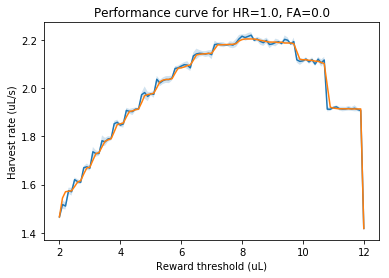

In [37]:
# Calculate harvest rate mean and std
mean = np.mean(r_total/t_total, axis=1)
std = np.std(r_total/t_total, axis=1)

# Smooth curve with 1D median filter
mean_smooth = np.zeros(mean.shape)
n = 10 # filter size
mean_smooth[0] = mean[0]
mean_smooth[-1] = mean[-1] # anchor at ends
for i in range(1, mean.shape[0]-1):
    mean_smooth[i] = np.median(mean[max(i-n//2, 0):min(i+n//2, mean.shape[0]-1)])

# Plot results
fig, ax = plt.subplots()
p_mean = ax.plot(decision_val, mean)
p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
p_mean_smooth = ax.plot(decision_val, mean_smooth)
p_xlabel = ax.set_xlabel('Reward threshold (uL)')
p_ylabel = ax.set_ylabel('Harvest rate (uL/s)')
p_title = ax.set_title('Performance curve for HR=1.0, FA=0.0')

print("Max harvest rate: %.2f uL/s" % np.max(mean_smooth))
print("Reward threshold at max: %.2f uL" % decision_val[np.argmax(mean_smooth)])

### Multiple hit rate, fa rate combinations

#### Run simulations

In [39]:
# Experiment parameters
num_steps_per_sim= 1000
num_sims_per_value = 5
exp_name = 'trial_1'
exp_desc = 'data shape = [hit_rate, fa_rate, reward_thresh, num_sims]'

# Environment parameters
d_interpatch = 25.0
r_init = 12.0
decay = 0.1
nc_avg = 1.0
target_duration = 1.0
max_trial_duration = 4.0
iti = 1.5
fa_timeout = 4.0
end_patch_type = None
end_patch_val = None

# Animal parameters
hit_rate = np.arange(11) / 10
fa_rate = np.arange(11) / 10
velocity = 5.0
decision_type = 'reward'
decision_val = np.linspace(2.0, 12.0, num=int((12.0-2.0)/0.1)+1)

# Create environment
patch = PatchEnvironment(d_interpatch,
                         r_init, 
                         decay,
                         nc_avg=nc_avg,
                         target_duration=target_duration,
                         max_trial_duration=max_trial_duration,
                         iti=iti,
                         fa_timeout=fa_timeout,
                         end_patch_type=end_patch_type,
                         end_patch_val=end_patch_val)


# Run simulations
r_total = np.zeros([hit_rate.shape[0], fa_rate.shape[0], decision_val.shape[0], num_sims_per_value])
t_total = np.zeros([hit_rate.shape[0], fa_rate.shape[0], decision_val.shape[0], num_sims_per_value])
num_patches = np.zeros([hit_rate.shape[0], fa_rate.shape[0], decision_val.shape[0], num_sims_per_value])
for i, hr in enumerate(hit_rate):
    for j, far in enumerate(fa_rate):
        print("Simulating hit rate %.2f, fa rate %.2f" % (hr, far))
        for k, dv in enumerate(decision_val):
            # Create animal object
            mouse = Rodent(hr,
                           far,
                           velocity,
                           decision_type,
                           dv)

            for l in range(num_sims_per_value):
                r_total[i, j, k, l], t_total[i, j, k, l], num_patches[i, j, k, l] = \
                    run_simulation(num_steps_per_sim, mouse, patch)

Simulating hit rate 0.00, fa rate 0.00
Simulating hit rate 0.00, fa rate 0.10
Simulating hit rate 0.00, fa rate 0.20
Simulating hit rate 0.00, fa rate 0.30
Simulating hit rate 0.00, fa rate 0.40
Simulating hit rate 0.00, fa rate 0.50
Simulating hit rate 0.00, fa rate 0.60
Simulating hit rate 0.00, fa rate 0.70
Simulating hit rate 0.00, fa rate 0.80
Simulating hit rate 0.00, fa rate 0.90
Simulating hit rate 0.00, fa rate 1.00
Simulating hit rate 0.10, fa rate 0.00
Simulating hit rate 0.10, fa rate 0.10
Simulating hit rate 0.10, fa rate 0.20
Simulating hit rate 0.10, fa rate 0.30
Simulating hit rate 0.10, fa rate 0.40
Simulating hit rate 0.10, fa rate 0.50
Simulating hit rate 0.10, fa rate 0.60
Simulating hit rate 0.10, fa rate 0.70
Simulating hit rate 0.10, fa rate 0.80
Simulating hit rate 0.10, fa rate 0.90
Simulating hit rate 0.10, fa rate 1.00
Simulating hit rate 0.20, fa rate 0.00
Simulating hit rate 0.20, fa rate 0.10
Simulating hit rate 0.20, fa rate 0.20
Simulating hit rate 0.20,

#### Save results

In [108]:
results_dir = 'G:\\My Drive\\Projects\\foraging\\data\\simulation_data\\%s\\' % exp_name
np.save(results_dir + 'r_total', r_total)
np.save(results_dir + 't_total', t_total)
np.save(results_dir + 'num_patches', num_patches)
np.save(results_dir + 'hit_rate', hit_rate)
np.save(results_dir + 'fa_rate', fa_rate)

In [109]:
f = open(results_dir + 'settings.txt', 'w')
f.write('Experiment params:\n')
f.write('Description: ' + exp_desc + '\n')
f.write('Steps per simulation = %d\n' % num_steps_per_sim)
f.write('Simulations per decision value = %d\n' % num_sims_per_value)
f.write('\nEnvironment params:\n')
f.write('d_interpatch = %.2f\n' % d_interpatch)
f.write('r_init = %.2f\n' % r_init)
f.write('decay = %.2f\n' % decay)
f.write('nc_avg = %.2f\n' % nc_avg)
f.write('target_duration = %.2f\n' % target_duration)
f.write('max_trial_duration = %.2f\n' % max_trial_duration)
f.write('iti = %.2f\n' % iti)
f.write('fa_timeout = %.2f\n' % fa_timeout)
f.write('end_patch_type = %s\n' % end_patch_type)
f.write('end_patch_val = %s\n' % str(end_patch_val))
f.write('\nAnimal params:\n')
if isinstance(hit_rate, np.ndarray):
    f.write('hit_rate = %s\n' %
            ('[' + ', '.join([str(hr) for hr in hit_rate]) + ']'))
else:
    f.write('hit_rate = %.2f\n' % hit_rate)
if isinstance(fa_rate, np.ndarray):
    f.write('fa_rate = %s\n' %
            ('[' + ', '.join([str(far) for far in fa_rate]) + ']'))
else:
    f.write('fa_rate = %.2f\n' % fa_rate)
f.write('velocity = %.2f\n' % velocity)
f.write('decision_type = %s\n' % decision_type)
if isinstance(decision_val, np.ndarray):
    f.write('decision_val = %s\n' % 
            ('[' + ', '.join([str(dv) for dv in decision_val]) + ']'))
else:
    f.write('decision_val = %.2f\n' % decision_val)
f.close()

#### Plot performance curves

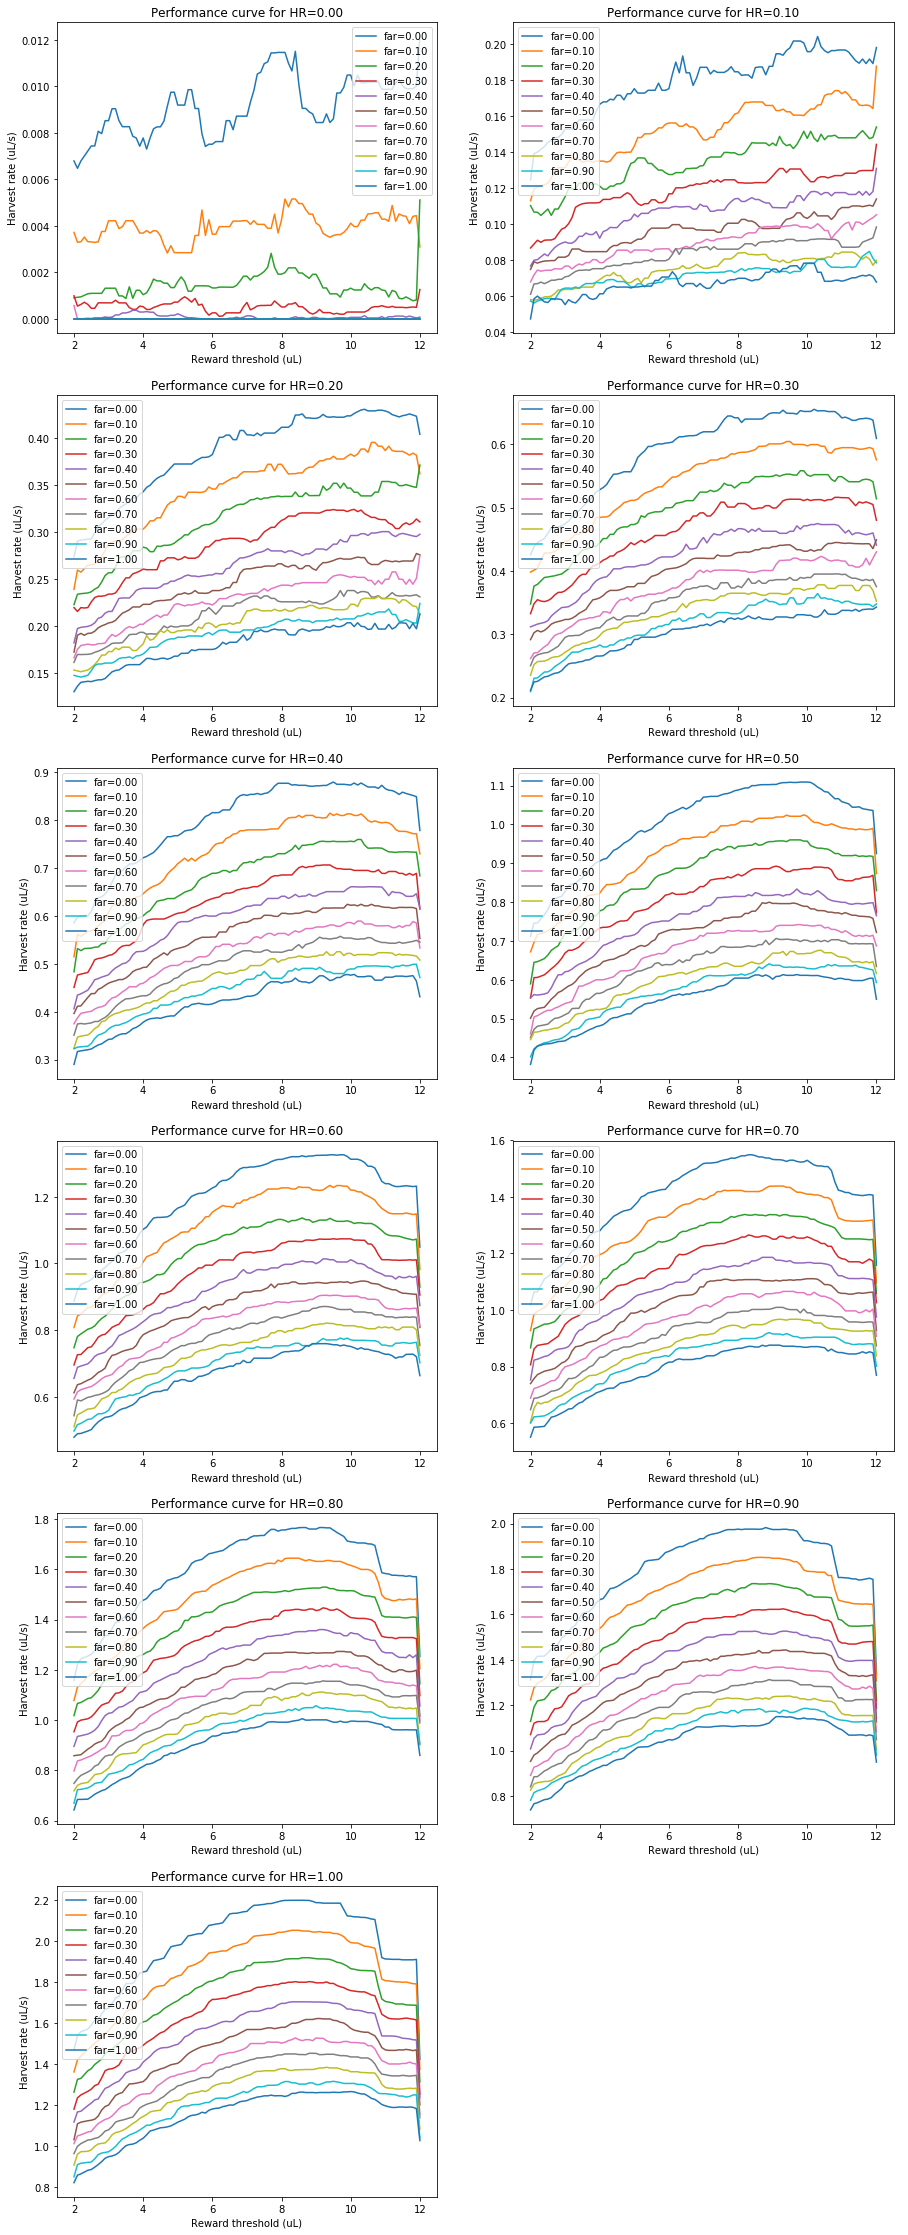

In [112]:
# Plot harvest rate vs. leaving threshold
harvest_rate = np.zeros([hit_rate.shape[0], fa_rate.shape[0]])
r_thresh = np.zeros([hit_rate.shape[0], fa_rate.shape[0]])
fig, ax = plt.subplots(fa_rate.shape[0]//2+1, 2, figsize=(15, 40))
for i, hr in enumerate(hit_rate):
    for j, far in enumerate(fa_rate):
        # Calculate harvest rate mean and std
        mean = np.mean(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)
        std = np.std(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)

        # Smooth curve with 1D median filter
        mean_smooth = np.zeros(mean.shape)
        n = 10 # filter size
        mean_smooth[0] = mean[0]
        mean_smooth[-1] = mean[-1] # anchor at ends
        for k in range(1, mean.shape[0]-1):
            mean_smooth[k] = np.median(mean[max(k-n//2, 0):min(k+n//2, mean.shape[0]-1)])
        harvest_rate[i, j] = np.max(mean_smooth)
        r_thresh[i, j] = decision_val[np.argmax(mean_smooth)]
        
        # Plot results
        #p_mean = ax.plot(decision_val, mean)
        #p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
        p_mean_smooth = ax[i//2, i%2].plot(decision_val, mean_smooth, label='far=%.2f' % (far))
        
    p_xlabel = ax[i//2, i%2].set_xlabel('Reward threshold (uL)')
    p_ylabel = ax[i//2, i%2].set_ylabel('Harvest rate (uL/s)')
    p_title = ax[i//2, i%2].set_title('Performance curve for HR=%.2f' % hr)
    l = ax[i//2, i%2].legend()

_ = ax[-1, -1].axis('off')

# Save plot
plt.savefig(results_dir + 'performance_curves.png')

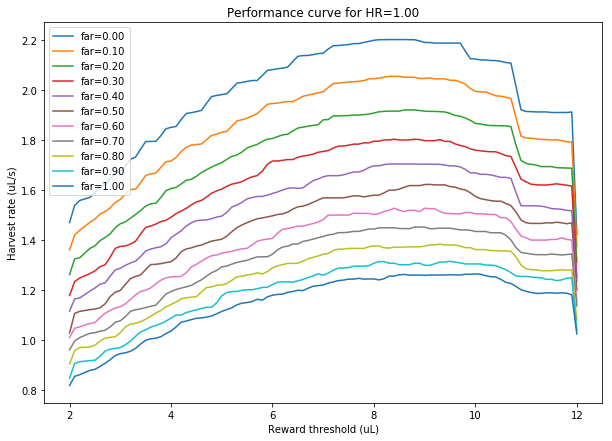

In [117]:
i = hit_rate.shape[0]-1
hr = hit_rate[i]
fig, ax = plt.subplots(figsize=(10, 7))
for j, far in enumerate(fa_rate):
    # Calculate harvest rate mean and std
    mean = np.mean(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)
    std = np.std(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)

    # Smooth curve with 1D median filter
    mean_smooth = np.zeros(mean.shape)
    n = 10 # filter size
    mean_smooth[0] = mean[0]
    mean_smooth[-1] = mean[-1] # anchor at ends
    for k in range(1, mean.shape[0]-1):
        mean_smooth[k] = np.median(mean[max(k-n//2, 0):min(k+n//2, mean.shape[0]-1)])
    harvest_rate[i, j] = np.max(mean_smooth)
    r_thresh[i, j] = decision_val[np.argmax(mean_smooth)]

    # Plot results
    #p_mean = ax.plot(decision_val, mean)
    #p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
    p_mean_smooth = ax.plot(decision_val, mean_smooth, label='far=%.2f' % (far))
        
p_xlabel = ax.set_xlabel('Reward threshold (uL)')
p_ylabel = ax.set_ylabel('Harvest rate (uL/s)')
p_title = ax.set_title('Performance curve for HR=%.2f' % hr)
l = ax.legend()

#### Plot heatmaps

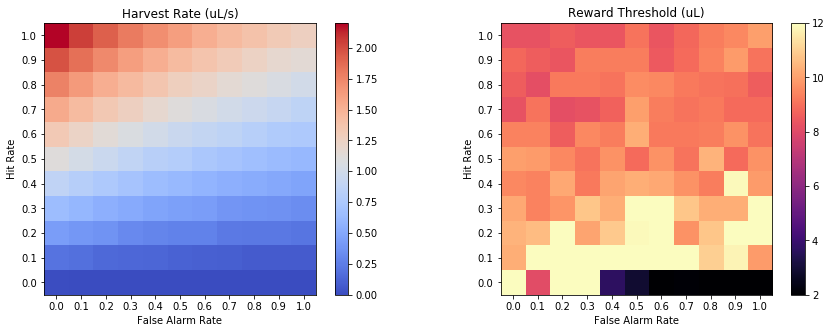

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot heatmap of harvest rate
heatmap = ax[0].imshow(harvest_rate[::-1, :], cmap='coolwarm')
cbar = fig.colorbar(heatmap, ax=ax[0])
xticks = ax[0].set_xticks(np.arange(11))
xtick_labels = ax[0].set_xticklabels(fa_rate)
yticks = ax[0].set_yticks(np.arange(11))
ytick_labels = ax[0].set_yticklabels(hit_rate[::-1])
xlabel = ax[0].set_xlabel('False Alarm Rate')
ylabel = ax[0].set_ylabel('Hit Rate')
title = ax[0].set_title('Harvest Rate (uL/s)')

# Plot heatmap of reward threshold
heatmap = ax[1].imshow(r_thresh[::-1, :], cmap='magma')
cbar = fig.colorbar(heatmap, ax=ax[1])
xticks = ax[1].set_xticks(np.arange(11))
xtick_labels = ax[1].set_xticklabels(fa_rate)
yticks = ax[1].set_yticks(np.arange(11))
ytick_labels = ax[1].set_yticklabels(hit_rate[::-1])
xlabel = ax[1].set_xlabel('False Alarm Rate')
ylabel = ax[1].set_ylabel('Hit Rate')
title = ax[1].set_title('Reward Threshold (uL)')

# Save plots
plt.savefig(results_dir + 'heatmaps.png')

### Compare simulation with behavioral data

In [118]:
import scipy.io as sio

In [124]:
f = open('Z:\James\data\matlist.txt', 'r')
for line in f:
    print(line)

Z:\James\data\ChamberA\07-06-18\j3z1_d02_2018_07_06_14_55_33.mat

Z:\James\data\ChamberA\07-06-18\j3z2_d02_2018_07_06_14_56_31.mat

Z:\James\data\ChamberA\07-06-18\j3z3_d02_2018_07_06_14_57_42.mat

Z:\James\data\ChamberA\07-06-18\j3z4_d02_2018_07_06_14_58_33.mat

Z:\James\data\ChamberA\07-09-18\j3z5_d04_2018_07_09_14_46_00.mat

Z:\James\data\ChamberA\07-09-18\j3z6_d04_2018_07_09_14_46_31.mat

Z:\James\data\ChamberA\07-10-18\j3z3_d05_2018_07_10_15_45_15.mat

Z:\James\data\ChamberA\07-10-18\j3z4_d05_2018_07_10_15_45_50.mat

Z:\James\data\ChamberA\07-10-18\j3z5_d05_2018_07_10_15_46_16.mat

Z:\James\data\ChamberA\07-10-18\j3z6_d05_2018_07_10_15_46_43.mat

Z:\James\data\ChamberA\07-11-18\j3z4_d6_2018_07_11_14_45_57.mat

Z:\James\data\ChamberA\07-11-18\j3z5_2018_07_11_14_45_58.mat

Z:\James\data\ChamberA\07-25-18\j3z2_d16_2018_07_25_14_23_14.mat

Z:\James\data\ChamberA\07-25-18\j3z3_d16_2018_07_25_14_23_19.mat

Z:\James\data\ChamberA\07-25-18\j3z4_d16_2018_07_25_14_23_20.mat

Z:\James\data\C

In [120]:
# For every file in filelist, simulate behavior with session parameters and compare with actual behavior (i.e. harvest rate, reward threshold)

<_io.TextIOWrapper name='Z:\\James\\data\\matlist.txt' mode='r' encoding='cp1252'>

## Reinforcement Learning Model

In [ ]:
class PatchEnvironment:
    
    def __init__(self, 
                 d_patch, 
                 d_interpatch, 
                 r_init, 
                 r_decay, 
                 episode_timeout):
        
        self.d_patch = d_patch
        self.d_interpatch = d_interpatch
        self.r_init = r_init
        self.r_decay = r_decay
        self.trial = 0
        self.step = 0
        self.episode_timeout = episode_timeout
        
    
        
    def _harvest_reward(self):
        """
        Give reward according exponential decay function for trial number in patch.
        """
        
        
        

In [ ]:
class Mouse:
    
    def __init__(self, 
                 hit_rate, 
                 fa_rate, 
                 velocity, 
                 thresh_type='reward', 
                 thresh_val=2.0):
        
        
    
    def make_action(self, action):
        """
        Either choose to stay in patch (and harvest reward) or leave patch (and incur travel time delay).
        """
        if action == 0: # stay in patch
            r = self._harvest_reward()
        else:
            r = self._leave_patch()
        
        
        self.step += 1
        is_terminal = self.step > episode_timeout
        
        return r, is_terminal